# Density-adjusted group connection test

In [1]:

import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.simulations import sbm
from pkg.io import glue as default_glue
from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import FIG_PATH, OUT_PATH, savefig
from pkg.perturb import remove_edges
from pkg.plot import (
    SmartSVG,
    draw_hypothesis_box,
    heatmap_grouped,
    networkplot_simple,
    plot_pvalues,
    set_theme,
)
from pkg.stats import stochastic_block_test
from svgutils.compose import Figure, Panel, Text
from tqdm import tqdm

DISPLAY_FIGS = False

FILENAME = "adjusted_sbm_unmatched_test"

OUT_PATH = OUT_PATH / FILENAME

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()
neutral_color = sns.color_palette("Set2")[2]

GROUP_KEY = "simple_group"

left_adj, left_nodes = load_unmatched(side="left")
right_adj, right_nodes = load_unmatched(side="right")

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

In [2]:

np.random.seed(888888)
ns = [5, 6, 7]
B = np.array([[0.8, 0.2, 0.05], [0.05, 0.9, 0.2], [0.05, 0.05, 0.7]])
A1, labels = sbm(ns, B, directed=True, loops=False, return_labels=True)

node_data = pd.DataFrame(index=np.arange(A1.shape[0]))
node_data["labels"] = labels + 1
palette = dict(zip(np.unique(labels) + 1, sns.color_palette("Set2")[3:]))


fig, axs = plt.subplots(
    2,
    2,
    figsize=(6, 5),
    # constrained_layout=True,
    gridspec_kw=dict(wspace=0.25, hspace=0, height_ratios=[2, 0.3]),
)


ytop = 1.05
ybottom = 0.11
xleft = 0.05
xright = 0.68
border_color = "lightgrey"
line1 = mpl.lines.Line2D(
    (0.15, 0.95),
    (0.4, 0.4),
    transform=fig.transFigure,
    color=border_color,
    linewidth=1.5,
)

# fig.lines = (line1,)


ax = axs[0, 0]
_, _, misc = stochastic_block_test(A1, A1, node_data["labels"], node_data["labels"])
Bhat1 = misc["probabilities1"].values
top_ax, left_ax = heatmap_grouped(Bhat1, [1, 2, 3], palette=palette, ax=ax)
top_ax.set_title(r"$\hat{B}^{(R)}$", color=network_palette["Right"], size="large")
ax.set_title(
    "Adjust connection probabilities\nfor group connection test",
    fontsize="large",
    x=1.1,
    y=1.3,
)

ax = axs[0, 1]
Bhat1 = misc["probabilities1"].values
top_ax, left_ax = heatmap_grouped(0.6 * Bhat1, [1, 2, 3], palette=palette, ax=ax)
top_ax.set_title(
    r"$\hat{B}^{(R)}$", color=network_palette["Right"], x=0.55, size="large"
)
top_ax.text(0.94, -1.2, r"$c$", size="large")

# ax.autoscale("off")
ax.annotate(
    "",
    xy=(0, 1.5),
    xytext=(-0.9, 1.5),
    arrowprops=dict(
        arrowstyle="simple",
        shrinkA=5,
        shrinkB=10,
        facecolor="black",
    ),
    zorder=1,
    clip_on=False,
)

from giskard.plot import merge_axes


ax = merge_axes(fig, axs, rows=1)
# ax.set_title("Run group\nconnection test", y=1.1, x=0.6, fontsize="small")
ax.axis("off")
ax.set(xlim=(0, 1), ylim=(0, 2))

draw_hypothesis_box("dasbm", 0.27, 2, ax=ax, yskip=1.2, ypad=0.03)

fig.set_facecolor("w")

gluefig("adjusted_methods_explain", fig)

In [3]:

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

node_data = networkplot_simple(A1, node_data, palette=palette, ax=ax, group=True)

n_select = 10
row_inds, col_inds = np.nonzero(A1)
np.random.seed(8888)
choice_inds = np.random.choice(len(row_inds), size=n_select)
for i in choice_inds:
    source_node = row_inds[i]
    target_node = col_inds[i]
    x1, y1 = node_data.loc[source_node, ["x", "y"]]
    x2, y2 = node_data.loc[target_node, ["x", "y"]]
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    ax.text(
        x,
        y,
        "x",
        va="center",
        ha="center",
        color="darkred",
        fontsize="medium",
        zorder=2,
    )


ax.set_title("Remove edges to\n match density (random)", fontsize="medium")
ax.set_ylabel(
    "Right",
    color=network_palette["Right"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

fig.set_facecolor("white")
gluefig("edge_removal_methods", fig)

In [4]:
n_edges_left = np.count_nonzero(left_adj)
n_edges_right = np.count_nonzero(right_adj)
n_left = left_adj.shape[0]
n_right = right_adj.shape[0]
density_left = n_edges_left / (n_left ** 2)
density_right = n_edges_right / (n_right ** 2)

n_remove = int((density_right - density_left) * (n_right ** 2))

glue("n_remove", n_remove)

In [5]:

rows = []
n_resamples = 500
glue("n_resamples", n_resamples)
RERUN_SIM = False

if RERUN_SIM:
    for i in tqdm(range(n_resamples)):
        subsampled_right_adj = remove_edges(
            right_adj, effect_size=n_remove, random_seed=rng
        )
        stat, pvalue, misc = stochastic_block_test(
            left_adj,
            subsampled_right_adj,
            labels1=left_labels,
            labels2=right_labels,
        )
        rows.append(
            {
                "stat": stat,
                "pvalue": pvalue,
                "misc": misc,
                "resample": i,
            }
        )
    resample_results = pd.DataFrame(rows)
    resample_results.to_csv(OUT_PATH / "resample_results.csv")
else:
    resample_results = pd.read_csv(OUT_PATH / "resample_results.csv", index_col=0)

In [6]:
stat, pvalue, misc = stochastic_block_test(
    left_adj,
    right_adj,
    labels1=left_labels,
    labels2=right_labels,
    method="fisher",
    density_adjustment=True,
)
glue("pvalue", pvalue, form="pvalue")
print(pvalue)
print(f"{pvalue:.2g}")

0.0023293637600989513
0.0023


In [7]:

set_theme(font_scale=1.25)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(
    data=resample_results,
    x="pvalue",
    ax=ax,
    color=neutral_color,
    kde=True,
    log_scale=True,
    stat="density",
)
ax.set(xlabel="p-value", ylabel="", yticks=[])
ax.spines["left"].set_visible(False)
ax.axvline(0.05, linestyle=":", color="black")
ylim = ax.get_ylim()
ax.text(0.06, ylim[1] * 0.9, r"$\alpha = 0.05$")

median_resample_pvalue = np.median(resample_results["pvalue"])

colors = sns.color_palette("Set2")


color = colors[2]
ax.axvline(median_resample_pvalue, color=color, linewidth=3)

ax.text(
    median_resample_pvalue - 0.0025,
    ylim[1] * 0.9,
    f"Median = {median_resample_pvalue:0.2g}",
    color=color,
    ha="right",
)

color = "darkred"
ax.axvline(pvalue, 0, 0.58, color=color, linewidth=3, linestyle="--")
ax.text(
    pvalue - 0.0002,
    ylim[1] * 0.48,
    f"Analytic = {pvalue:0.2g}",
    ha="right",
    color=color,
)

gluefig("resampled_pvalues_distribution", fig)

In [8]:

fig, axs = plot_pvalues(misc)

gluefig("sbm_pvalues", fig)

fig, axs = plot_pvalues(misc, annot_missing=False)

gluefig("sbm_pvalues_unlabeled", fig)

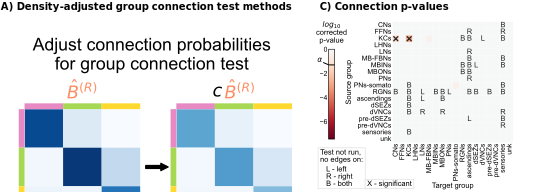

In [9]:


fontsize = 10

methods = SmartSVG(FIG_PATH / "adjusted_methods_explain.svg")
methods.set_width(350)
methods.move(15, 35)
methods_panel = Panel(
    methods,
    Text(
        "A) Density-adjusted group connection test methods",
        0,
        10,
        size=fontsize,
        weight="bold",
    ),
)


pvalues = SmartSVG(FIG_PATH / "sbm_pvalues.svg")
pvalues.set_width(250)
pvalues.move(0, 20)
pvalues_panel = Panel(
    pvalues,
    Text("C) Connection p-values", 5, 10, size=fontsize, weight="bold"),
)
pvalues_panel.move(methods.width * 0.9, 0)

fig = Figure(
    (methods.width + pvalues.width) * 0.9,
    (pvalues.height) * 0.9,
    methods_panel,
    pvalues_panel,
)
fig.save(FIG_PATH / "adjusted_sbm_composite.svg")
fig

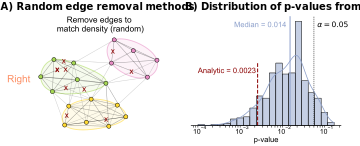

In [10]:
methods = SmartSVG(FIG_PATH / "edge_removal_methods.svg")
methods.set_width(200)
methods.move(5, 15)
methods_panel = Panel(
    methods,
    Text(
        "A) Random edge removal methods",
        0,
        10,
        size=fontsize,
        weight="bold",
    ),
)

distribution = SmartSVG(FIG_PATH / "resampled_pvalues_distribution.svg")
distribution.set_width(200)
distribution.move(10, 15)
distribution_panel = Panel(
    distribution,
    Text(
        "B) Distribution of p-values from subsamples",
        5,
        10,
        size=fontsize,
        weight="bold",
    ),
)
distribution_panel.move(methods.width * 0.9, 0)

fig = Figure(
    (methods.width + distribution.width) * 0.9,
    (distribution.height) * 0.9,
    methods_panel,
    distribution_panel,
)
fig.save(FIG_PATH / "adjusted_sbm_random_composite.svg")
fig

In [11]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:12.017001
Completed at 2022-04-13 16:43:54.769808
